In [1]:
!pip install ucimlrepo
!python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import pickle
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score


# PASO 1: Cargar y limpiar los datos


In [ ]:
# Descargar el conjunto de datos
print("Descargando y preparando el conjunto de datos...")
autistic_spectrum_disorder_screening_data = fetch_ucirepo(id=419)

Descargando y preparando el conjunto de datos...


In [ ]:
# Extraer los datos X (características) e y (etiqueta de clase)
df = autistic_spectrum_disorder_screening_data.data.features
y = autistic_spectrum_disorder_screening_data.data.targets

In [ ]:
# Eliminar las columnas no deseadas
df_cleaned = df.drop(columns=['age', 'ethnicity', 'country_of_res', 'used_app_before', 'age_desc', 'relation', 'result'])


In [ ]:
# Renombrar las columnas de A1_Score a A10_Score para facilitar el acceso
rename_dict = {f'A{i}_Score': f'a{i}' for i in range(1, 11)}
df_cleaned.rename(columns=rename_dict, inplace=True)

In [7]:
# Si df es un subconjunto de otro DataFrame, haz una copia primero
df = df.copy()

rename_dict = {f'A{i}_Score': f'a{i}' for i in range(1, 11)}
df.rename(columns=rename_dict, inplace=True)

In [8]:
# Mapeo de respuestas binarias (sí/no) y género a 1/0
binary_columns = ['jaundice', 'autism'] + [f'a{i}' for i in range(1, 11)]

for col in binary_columns:
    if col in df_cleaned.columns:
        if df_cleaned[col].dtype == 'object':
            df_cleaned.loc[:, col] = df_cleaned[col].str.lower().map({'yes': 1, 'no': 0})
        else:
            # Para las columnas 'a1' a 'a10' que ya son numéricas
            df_cleaned.loc[:, col] = pd.to_numeric(df_cleaned[col], errors='coerce')

if 'gender' in df_cleaned.columns:
    df_cleaned.loc[:, 'gender'] = df_cleaned['gender'].str.lower().map({'f': 0, 'm': 1})



In [9]:
# Manejo de posibles valores nulos creados durante la coerción
df_cleaned.fillna(0, inplace=True)
df_cleaned.head()

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,gender,jaundice,autism
0,1,1,0,0,1,1,0,1,0,0,1,0,0
1,1,1,0,0,1,1,0,1,0,0,1,0,0
2,1,1,0,0,0,1,1,1,0,0,1,0,0
3,0,1,0,0,1,1,0,0,0,1,0,1,0
4,1,1,1,1,1,1,1,1,1,1,1,1,0


In [ ]:
# Codificar la variable objetivo 'y' a formato numérico
# Asegurar que y_encoded sea un DataFrame con el nombre de columna correcto
y_encoded = pd.DataFrame(y.iloc[:, 0].map({'YES': 1, 'NO': 0}))
# Renombrar la columna inmediatamente después de crear el DataFrame para asegurar que se llame 'Class/ASD'
y_encoded.rename(columns={y_encoded.columns[0]: 'Class/ASD'}, inplace=True)

print("Preparación de datos completa.")

Preparación de datos completa.


# PASO 2: Calcular y visualizar la correlación

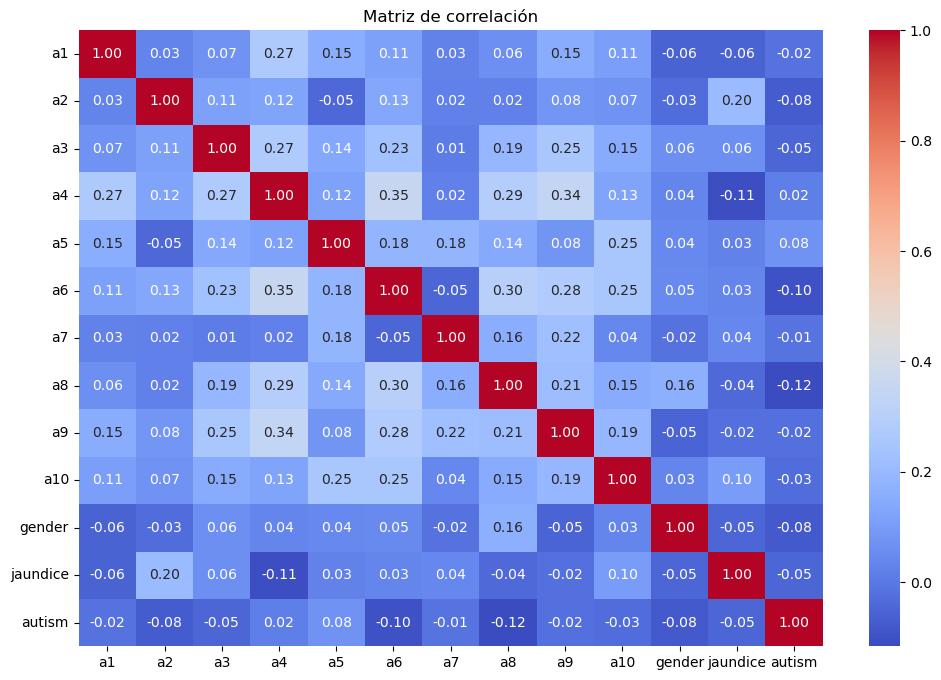

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df_cleaned.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

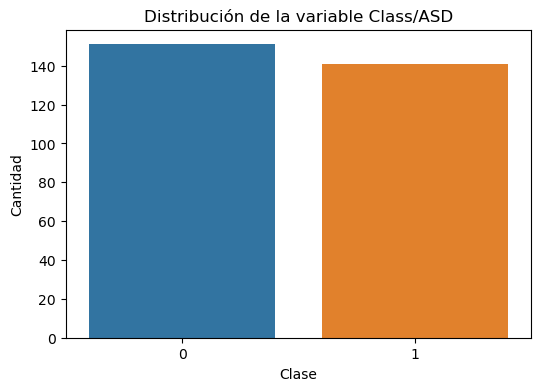

In [12]:
# Gráfico de barras para la variable 'Class/ASD'
plt.figure(figsize=(6,4))
sns.countplot(data=y_encoded, x='Class/ASD')
plt.title('Distribución de la variable Class/ASD')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

In [ ]:
# Asegurar de que todas las columnas sean numéricas antes de calcular la correlación
df_numeric = df_cleaned.apply(pd.to_numeric, errors='coerce')

# Calcular la correlación de cada variable con la clase objetivo
target_corr = df_numeric.corrwith(y_encoded['Class/ASD'])

print("\nValores de Correlación con la Clase Objetivo:")
print(target_corr)


Valores de Correlación con la Clase Objetivo:
a1          0.393534
a2          0.229045
a3          0.395545
a4          0.568502
a5          0.379859
a6          0.417271
a7          0.273949
a8          0.438389
a9          0.486163
a10         0.439942
gender      0.038782
jaundice   -0.025049
autism     -0.048800
dtype: float64


# PASO 3: Crear Red neuronal Artificial DNN

In [14]:
# Funciones de activación y derivadas
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # estabilidad numérica
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)



In [15]:
# Función de pérdida: entropía cruzada
def cross_entropy(y_hat, y):
    m = y.shape[1]
    return -np.sum(y * np.log(y_hat + 1e-9)) / m  # evitar log(0)

In [16]:
# Inicialización de pesos y biases
def initialize_parameters():
    np.random.seed(42)
    W1 = np.random.randn(30, 13) * np.sqrt(2. / 13)  # He initialization
    b1 = np.zeros((30, 1))
    W2 = np.random.randn(3, 30) * np.sqrt(2. / 30)
    b2 = np.zeros((3, 1))
    W3 = np.random.randn(2, 3) * np.sqrt(2. / 3)
    b3 = np.zeros((2, 1))
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

In [17]:
# Propagación hacia adelante
def forward_propagation(X, params):
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    W3, b3 = params["W3"], params["b3"]

    Z1 = W1 @ X + b1
    A1 = relu(Z1)

    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)

    Z3 = W3 @ A2 + b3
    A3 = softmax(Z3)

    cache = {"A0": X, "Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, cache

In [18]:
# Retropropagación
def backward_propagation(Y_hat, Y, cache, params):
    m = Y.shape[1]

    dZ3 = Y_hat - Y  # derivada de entropía cruzada con softmax
    dW3 = dZ3 @ cache["A2"].T / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m

    dA2 = params["W3"].T @ dZ3
    dZ2 = dA2 * relu_derivative(cache["Z2"])
    dW2 = dZ2 @ cache["A1"].T / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dA1 = params["W2"].T @ dZ2
    dZ1 = dA1 * relu_derivative(cache["Z1"])
    dW1 = dZ1 @ cache["A0"].T / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    gradients = {"dW1": dW1, "db1": db1,
                 "dW2": dW2, "db2": db2,
                 "dW3": dW3, "db3": db3}
    return gradients

In [19]:
# Actualización de parámetros
def update_parameters(params, grads, learning_rate):
    for key in params:
        params[key] -= learning_rate * grads["d" + key]
    return params

In [20]:
# Entrenamiento
def train(X, Y, epochs=1000, learning_rate=0.01, print_loss=True):
    params = initialize_parameters()
    for i in range(epochs):
        Y_hat, cache = forward_propagation(X, params)
        loss = cross_entropy(Y_hat, Y)
        grads = backward_propagation(Y_hat, Y, cache, params)
        params = update_parameters(params, grads, learning_rate)

        if print_loss and i % 100 == 0:
            print(f"Epoch {i} - Loss: {loss:.4f}")
    return params

In [21]:
# Predicción
def predict(X, params):
    Y_hat, _ = forward_propagation(X, params)
    return np.argmax(Y_hat, axis=0)

# PASO 4: Evaluar Red neuronal Artificial DNN

In [22]:
# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

In [23]:
# One-hot encoding para etiquetas
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

In [ ]:
# ---------------------------
# División 60% - 20% - 20%
# ---------------------------
# Dividir entre entrenamiento (60%) y pruebas (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.4, stratify=y, random_state=42
)


In [ ]:
# Dividir el 40% restante entre validación (20%) y prueba (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [26]:
# Transponer para red neuronal (features, samples)
X_train, y_train = X_train.T, y_train.T
X_val, y_val = X_val.T, y_val.T
X_test, y_test = X_test.T, y_test.T

In [29]:
# Entrenamiento con validación y early stopping
def train_with_validation(X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.01, patience=20):
    dnn = initialize_parameters()
    best_loss = float('inf')
    best_params = None
    wait = 0

    train_losses = []
    val_losses = []

    for i in range(epochs):
        # Forward y pérdida en entrenamiento
        y_hat_train, cache_train = forward_propagation(X_train, dnn)
        train_loss = cross_entropy(y_hat_train, y_train)
        train_losses.append(train_loss)

        # Forward y pérdida en validación
        y_hat_val, _ = forward_propagation(X_val, dnn)
        val_loss = cross_entropy(y_hat_val, y_val)
        val_losses.append(val_loss)

        # Verificar si mejoró
        if val_loss < best_loss - 1e-4:
            best_loss = val_loss
            best_params = {k: v.copy() for k, v in dnn.items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"⏹️ Early stopping en la época {i}")
                break

        # Retropropagación y actualización
        grads = backward_propagation(y_hat_train, y_train, cache_train, dnn)
        dnn = update_parameters(dnn, grads, learning_rate)

        if i % 100 == 0:
            print(f"Época {i} - Pérdida Entrenamiento: {train_loss:.4f}, Validación: {val_loss:.4f}")

    # Gráfico de pérdida
    plt.plot(train_losses, label="Entrenamiento")
    plt.plot(val_losses, label="Validación")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title("Evolución de la pérdida")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_params

Época 0 - Pérdida Entrenamiento: 0.7390, Validación: 0.7436
Época 100 - Pérdida Entrenamiento: 0.2545, Validación: 0.3278
Época 200 - Pérdida Entrenamiento: 0.0824, Validación: 0.1575
Época 300 - Pérdida Entrenamiento: 0.0400, Validación: 0.1149
Época 400 - Pérdida Entrenamiento: 0.0212, Validación: 0.0851
Época 500 - Pérdida Entrenamiento: 0.0122, Validación: 0.0662
Época 600 - Pérdida Entrenamiento: 0.0082, Validación: 0.0572
Época 700 - Pérdida Entrenamiento: 0.0060, Validación: 0.0512
Época 800 - Pérdida Entrenamiento: 0.0046, Validación: 0.0467
Época 900 - Pérdida Entrenamiento: 0.0037, Validación: 0.0432


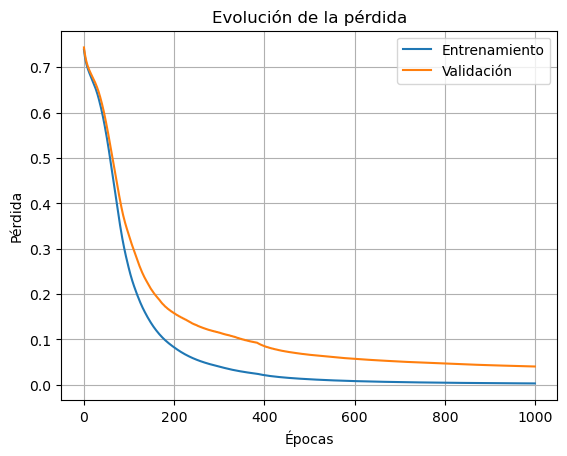

Validación Accuracy: 0.9655
Prueba Accuracy: 1.0000


1.0

In [30]:
dnn = train_with_validation(X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.05, patience=30)

evaluate(X_val, y_val, dnn, name="Validación")
evaluate(X_test, y_test, dnn, name="Prueba")


In [31]:
def evaluate(X, y_true, params, name="Evaluación"):
    y_hat, _ = forward_propagation(X, params)
    
    # Convertir a etiquetas
    y_pred_labels = np.argmax(y_hat, axis=0)
    y_true_labels = np.argmax(y_true, axis=0)

    # Calcular métricas
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    recall = recall_score(y_true_labels, y_pred_labels)      # Sensitivity
    precision = precision_score(y_true_labels, y_pred_labels)
    f1 = f1_score(y_true_labels, y_pred_labels)
    roc_auc = roc_auc_score(y_true_labels, y_hat[1, :])      # Probabilidades para clase positiva

    # Imprimir resultados
    print(f"\n📊 Resultados de {name}:")
    print(f"🔹 Accuracy:             {accuracy:.4f}")
    print(f"🔹 Sensitivity (Recall): {recall:.4f}")
    print(f"🔹 Precisión:            {precision:.4f}")
    print(f"🔹 F1-Score:             {f1:.4f}")
    print(f"🔹 ROC AUC:              {roc_auc:.4f}")

In [32]:
evaluate(X_train, y_train, dnn, name="Entrenamiento")
evaluate(X_test, y_test, dnn, name="Pruebas")
evaluate(X_val, y_val, dnn, name="Validación")


📊 Resultados de Entrenamiento:
🔹 Accuracy:             1.0000
🔹 Sensitivity (Recall): 1.0000
🔹 Precisión:            1.0000
🔹 F1-Score:             1.0000
🔹 ROC AUC:              1.0000

📊 Resultados de Pruebas:
🔹 Accuracy:             1.0000
🔹 Sensitivity (Recall): 1.0000
🔹 Precisión:            1.0000
🔹 F1-Score:             1.0000
🔹 ROC AUC:              1.0000

📊 Resultados de Validación:
🔹 Accuracy:             0.9655
🔹 Sensitivity (Recall): 0.9643
🔹 Precisión:            0.9643
🔹 F1-Score:             0.9643
🔹 ROC AUC:              0.9988


In [33]:
def plot_roc_curve(X, y_true, dnn, name="ROC Curve"):
    # Obtener predicciones con forward propagation
    y_hat, _ = forward_propagation(X, dnn)

    # Solo usamos la probabilidad de la clase positiva (índice 1)
    y_scores = y_hat[1, :]  # Clase positiva
    y_true_labels = np.argmax(y_true, axis=0)  # Valores verdaderos

    # Calcular puntos de la curva ROC
    fpr, tpr, _ = roc_curve(y_true_labels, y_scores)
    roc_auc = auc(fpr, tpr)

    # Graficar
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área bajo la curva = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Aleatorio')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC - {name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


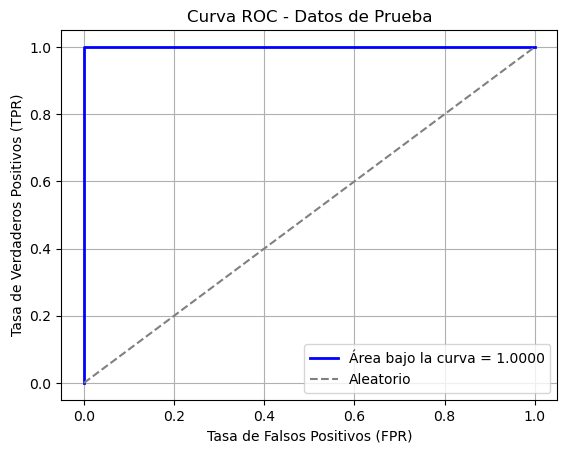

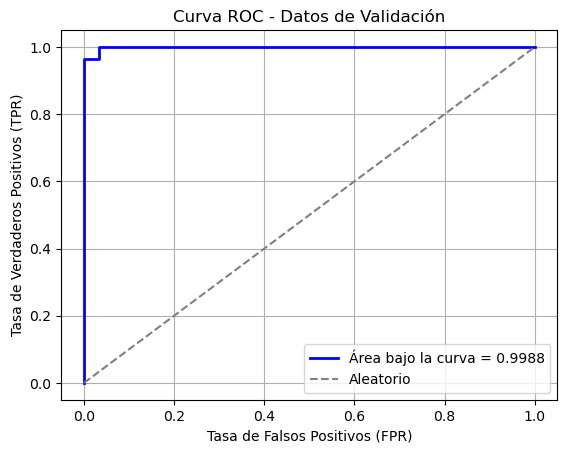

In [34]:
plot_roc_curve(X_test, y_test, dnn, name="Datos de Prueba")
plot_roc_curve(X_val, y_val, dnn, name="Datos de Validación")


In [35]:
def variable_importance(dnn, feature_names=None):
    W1 = dnn["W1"]  # W1 shape: (n_hidden_neurons, n_features)

    # Importancia como la suma del valor absoluto de los pesos por cada feature
    importance_raw = np.sum(np.abs(W1), axis=0)

    # Normalización
    importance_norm = importance_raw / np.sum(importance_raw)

    # Crear DataFrame
    df_importance = pd.DataFrame({
        "Variable": feature_names if feature_names else [f"Var{i+1}" for i in range(len(importance_norm))],
        "Importance": importance_raw,
        "Normalized Importance": importance_norm
    })

    # Ordenar
    df_importance = df_importance.sort_values(by="Normalized Importance", ascending=False).reset_index(drop=True)

    print("\n📈 INDEPENDENT VARIABLE IMPORTANCE VALUES OF THE DNN MODEL")
    print(df_importance.to_string(index=False))

    return df_importance

In [36]:
# Usar los nombres de las columnas numéricas utilizadas en la red neuronal
feature_names = df_numeric.columns.tolist()

# Llamada a la función después del entrenamiento
variable_importance(dnn, feature_names)


📈 INDEPENDENT VARIABLE IMPORTANCE VALUES OF THE DNN MODEL
Variable  Importance  Normalized Importance
     a10   10.899115               0.091300
      a1   10.595010               0.088753
  gender   10.461357               0.087633
      a2   10.263958               0.085980
      a3    9.792162               0.082027
      a7    9.319395               0.078067
      a5    8.910322               0.074640
jaundice    8.809960               0.073800
      a6    8.285201               0.069404
      a8    8.239042               0.069017
  autism    8.235294               0.068986
      a9    8.215338               0.068819
      a4    7.350462               0.061574


,Variable,Importance,Normalized Importance
0,a10,10.899115,0.091300
1,a1,10.595010,0.088753
2,gender,10.461357,0.087633
3,a2,10.263958,0.085980
4,a3,9.792162,0.082027
5,a7,9.319395,0.078067
6,a5,8.910322,0.074640
7,jaundice,8.809960,0.073800
8,a6,8.285201,0.069404
9,a8,8.239042,0.069017


In [37]:
def model_summary(X_train, Y_train, X_test, Y_test, X_val, Y_val, dnn):
    def compute_metrics(X, Y, name):
        Y_hat, _ = forward_propagation(X, dnn)
        Y_pred_labels = np.argmax(Y_hat, axis=0)
        Y_true_labels = np.argmax(Y, axis=0)

        # Cross-Entropy Error
        error = cross_entropy(Y_hat, Y)

        # Porcentaje de predicciones incorrectas
        incorrect_pct = 100 * np.mean(Y_pred_labels != Y_true_labels)

        print(f"\n📋 {name} Summary")
        print(f"Cross-Entropy Error:            {error:.4f}")
        print(f"Percent Incorrect Predictions:  {incorrect_pct:.2f}%")

        return error, incorrect_pct

    print("\n📊 THE MODEL SUMMARY INFORMATION FOR BOTH TRAINING AND TESTING STAGES")
    compute_metrics(X_train, Y_train, "Entrenamiento")
    compute_metrics(X_test, Y_test, "Pruebas")
    compute_metrics(X_val, Y_val, "Validación")

In [38]:
model_summary(X_train, y_train, X_test, y_test, X_val, y_val, dnn)



📊 THE MODEL SUMMARY INFORMATION FOR BOTH TRAINING AND TESTING STAGES

📋 Entrenamiento Summary
Cross-Entropy Error:            0.0031
Percent Incorrect Predictions:  0.00%

📋 Pruebas Summary
Cross-Entropy Error:            0.0294
Percent Incorrect Predictions:  0.00%

📋 Validación Summary
Cross-Entropy Error:            0.0405
Percent Incorrect Predictions:  3.45%


# 5. Guardar el modelo

In [ ]:
# Guardar el modelo, scaler y encoder para uso en Streamlit en la ruta especificada
with open(r'models/dnn_streamlit.pkl', 'wb') as f:
    pickle.dump({'dnn': dnn, 'scaler': scaler, 'encoder': encoder, 'feature_names': feature_names}, f)